In [1]:
%matplotlib inline
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import madrigalWeb.madrigalWeb
import os
import h5py
import numpy as np

In [2]:
#CHANGE ME
user_fullname = "Student Example"
user_email = "isr.summer.school@gmail.com"
user_affiliation = "ISR Summer School 2024"

maddat = madrigalWeb.madrigalWeb.MadrigalData('https://data.amisr.com/madrigal/')

In [3]:
#instrument codes for AMISR
instcodes={'PFISR':61,
          'RISR-N':91,
          'RISR-C':92}

In [4]:
#start time
st=datetime.datetime(2011,8,4,0,0,0)
et=datetime.datetime(2011,8,5,0,0,0)
expList = maddat.getExperiments(instcodes['PFISR'], st.year, st.month, st.day, st.hour, st.minute, st.second, et.year, et.month, et.day, et.hour, et.minute, et.second)
for exp in expList:
    print(exp)

id: 30002620
realUrl: http://data.amisr.com/madrigal/showExperiment/?experiment_list=30002620
url: http://data.amisr.com/madrigal/madtoc/experiments0/2011/pfa/01aug11a
name: MSWinds23 - D-region E-region F-region local measurements
siteid: 3
sitename: SRI
instcode: 61
instname: Poker Flat IS Radar
startyear: 2011
startmonth: 8
startday: 1
starthour: 0
startmin: 4
startsec: 43
endyear: 2011
endmonth: 8
endday: 5
endhour: 22
endmin: 26
endsec: 27
isLocal: True
madrigalUrl: http://https://data.amisr.com/madrigal
PI: Asti Bhatt
PIEmail: asti.bhatt@sri.com
uttimestamp: 1720837610
access: 0
Madrigal version: 3.4



In [5]:
# Get all the files associated with the experiment:
fileList = maddat.getExperimentFiles(expList[0].id)
for file in fileList:
    print(os.path.basename(file.name),'\tkindat:',file.kindat,'desc:',file.kindatdesc)

pfa20110801.001_bc_nenotr_15sec.002.h5 	kindat: 1000368 desc: Ne From Power - Barker/MPS Code (D-region) - 15 sec
pfa20110801.001_bc_nenotr_01min.002.h5 	kindat: 1000301 desc: Ne From Power - Barker/MPS Code (D-region) - 1 min
pfa20110801.001_ac_nenotr_05min.002.h5 	kindat: 1000205 desc: Ne From Power - Alternating Code (E-region) - 5 min
pfa20110801.001_ac_fit_05min.002.h5 	kindat: 2000205 desc: Fitted - Alternating Code (E-region) - 5 min
pfa20110801.001_lp_nenotr_03min.002.h5 	kindat: 1000103 desc: Ne From Power - Long Pulse (F-region) - 3 min
pfa20110801.001_lp_fit_03min.002.h5 	kindat: 2000103 desc: Fitted - Long Pulse (F-region) - 3 min
pfa20110801.001_lp_vvels_05min.002.h5 	kindat: 3000105 desc: Resolved Velocity - Long Pulse (F-region) - 5 min
pfa20110801.001_lp_vvels_03min.002.h5 	kindat: 3000103 desc: Resolved Velocity - Long Pulse (F-region) - 3 min


In [6]:
#fileList = maddat.getExperimentFiles(expList[0].id)
bcfile=None
for file in fileList:
    if 'Ne From Power' in file.kindatdesc:
        if 'D-region' in  file.kindatdesc:
            if '1 min' in  file.kindatdesc:
                bcfile=file
                break
        
filename     = bcfile.name
outfilename  = os.path.basename(bcfile.name)
result = maddat.downloadFile(filename, outfilename, user_fullname, user_email, user_affiliation, 'hdf5')

In [7]:
with h5py.File(outfilename,'r') as f:
    PFISR_data = []
    for dat in f['Data/Array Layout'].values():
        outdct={}
        outdct['bid'] = dat['1D Parameters/beamid'][0]
        outdct['azm'] = dat['1D Parameters/azm'][0]
        outdct['elm'] = dat['1D Parameters/elm'][0]
        outdct['ne'] = 10**(dat['2D Parameters/popl'][:])
        outdct['dne'] = 10**(dat['2D Parameters/dpopl'][:])
        
        outdct['range'] = dat['range'][:]
        outdct['altitude'] = outdct['range']*np.sin(np.radians(outdct['elm']))
        tstmp = dat['timestamps'][:]
        outdct['time'] = [datetime.datetime.utcfromtimestamp(t) for t in tstmp]
        PFISR_data.append(outdct)

In [8]:
for i,d in enumerate(PFISR_data):
    print(f"{d['bid']}  {d['azm']:.2f}\t{d['elm']:.2f}")

64016  14.04	90.00
64157  -154.30	77.50
64964  -34.69	66.09
65066  75.03	65.56


In [9]:
#find the vertical beam 
bver_ind  = np.argmin(np.abs(np.array([x['elm'] for x in PFISR_data]) - ( 90.0)))
bdat    = PFISR_data[bver_ind]

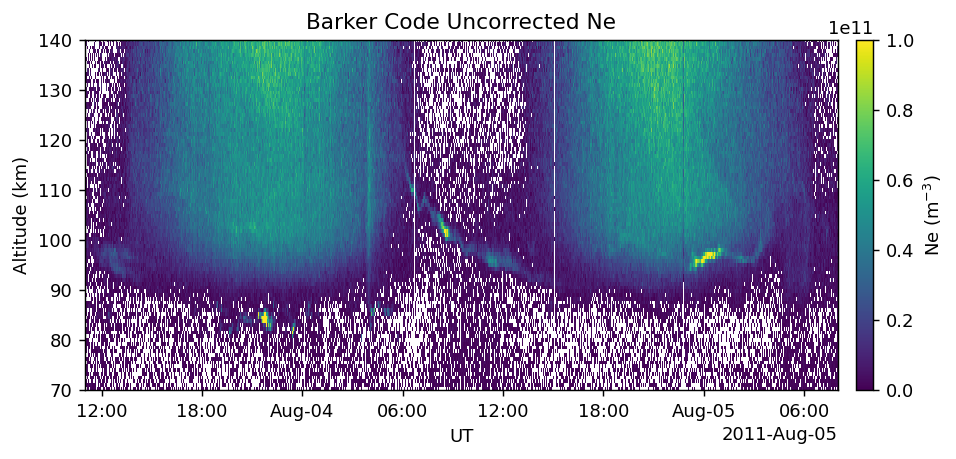

In [10]:
fig,ax=plt.subplots(dpi=130, figsize=(9,3.5))
clrs = ax.pcolormesh(mdates.date2num(bdat['time']),bdat['altitude'],bdat['ne'],vmin=0,vmax=1e11,shading='nearest')
ax.set_xlim([mdates.date2num(datetime.datetime(2011,8,3,11,0,0)),
             mdates.date2num(datetime.datetime(2011,8,5,8,0,0))])
ax.set_ylim([70,140])
locator = mdates.AutoDateLocator(minticks=8, maxticks=9)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlabel('UT')
ax.set_ylabel('Altitude (km)')
ax.set_title('Barker Code Uncorrected Ne')

cb=fig.colorbar(clrs, pad=0.02)
cb.set_label('Ne (m$^{-3}$)')

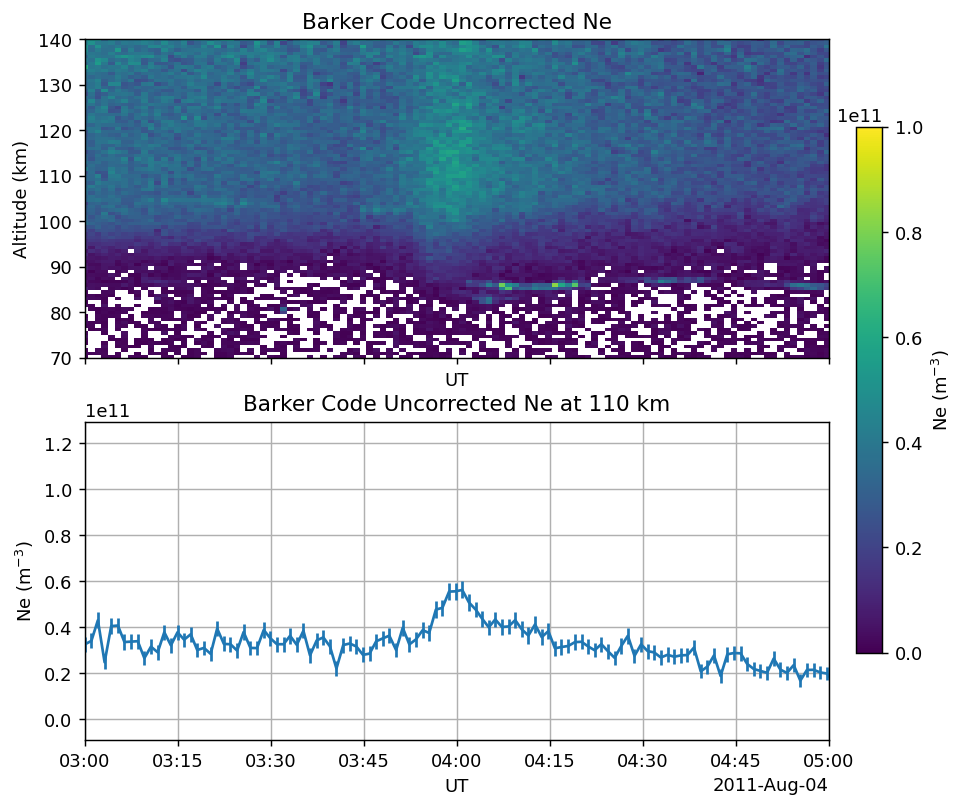

In [11]:
fig,axarr=plt.subplots(nrows=2, dpi=130, figsize=(9,7), sharex=True)
ax = axarr[0]
clrs = ax.pcolormesh(mdates.date2num(bdat['time']),bdat['altitude'],bdat['ne'],vmin=0,vmax=1e11,shading='nearest')
ax.set_xlim([mdates.date2num(datetime.datetime(2011,8,4,3,0,0)),
             mdates.date2num(datetime.datetime(2011,8,4,5,0,0))])
ax.set_ylim([70,140])
locator = mdates.AutoDateLocator(minticks=8, maxticks=9)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlabel('UT')
ax.set_ylabel('Altitude (km)')
ax.set_title('Barker Code Uncorrected Ne')

cb=fig.colorbar(clrs,ax=axarr, pad=0.03, shrink=0.75)
cb.set_label('Ne (m$^{-3}$)')

#Pick out 110 km
ax = axarr[1]
hindex0=np.argmin(np.abs(bdat['altitude']-110.0))
ax.errorbar(mdates.date2num(bdat['time']),bdat['ne'][hindex0,:], 
                  yerr=bdat['dne'][hindex0,:])
ax.set_ylabel('Ne (m$^{-3}$)')
ax.set_title('Barker Code Uncorrected Ne at 110 km')
ax.set_xlabel('UT')
ax.grid()


# Questions

1. The first plot shows 2 days-worth of data in UT time. Where are sunrise and sunset on each day? How can you tell even if the time axis wasn't labled?

2. The zoomed in second plot shows a special event at 4 UT. What happened? (Hint, you may find it useful to look at the NOAA GOES X-ray Data: GOES X-ray data ftp://ftp.swpc.noaa.gov/pub/warehouse/2011/2011_plots  2011_xray.tar.gz ftp://ftp.swpc.noaa.gov/pub/warehouse/2011  2011_events.tar.gz)

## Extra Questions

3. What are the thin layers of electron density in the zoomed out plot between 90 and 110 km?

4. What are the thin layers of scatter between 80 and 90 km? (Hint, this is summer-time data, and those echoes are not actually incoherent scatter from electron density enhancements).